#  DQN

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Саттон Р.	С.,	Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* https://en.wikipedia.org/wiki/Q-learning
* https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://github.com/pylSER/Deep-Reinforcement-learning-Mountain-Car/tree/master
* https://valohai.com/blog/reinforcement-learning-tutorial-basic-deep-q-learning/

## Задачи для совместного разбора

1\. Обсудите основные отличия DQN от классических вариантов Q-learning.

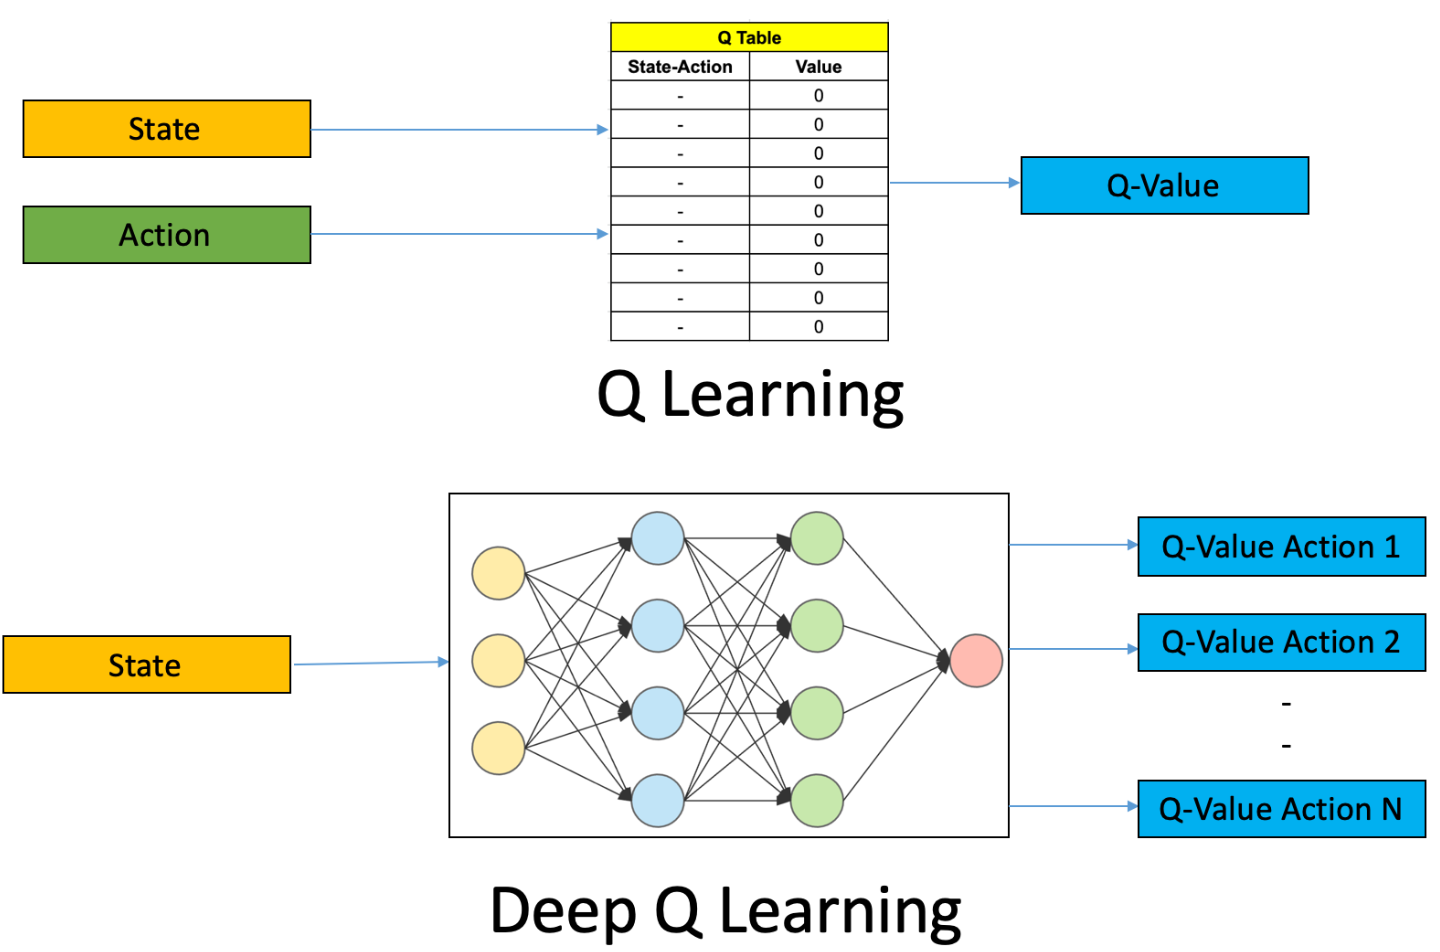

<img src="https://valohai.com/blog/reinforcement-learning-tutorial-part-1-q-learning/image4.png" width="500">
<img src="https://valohai.com/blog/reinforcement-learning-tutorial-basic-deep-q-learning/4.png" width="500">


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Допишите класс `ReplayMemory` для хранения переходов между состояниями.

- [ ] Проверено на семинаре

In [1]:
from collections import namedtuple, deque
import random

Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward', 'done')
)

class ReplayMemory(object):
    def __init__(self, capacity):
        """capacity - максимальный размер хранилища"""
        self.capacity = int(capacity)
        self.memory = deque(maxlen=self.capacity)

    def push(self, *args):
        """Сохраняет переход. При нехватке места в хранилище самые старые записи удаляются."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Возвращает batch_size случайно выбранных переходов"""
        batch_size = int(batch_size)
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

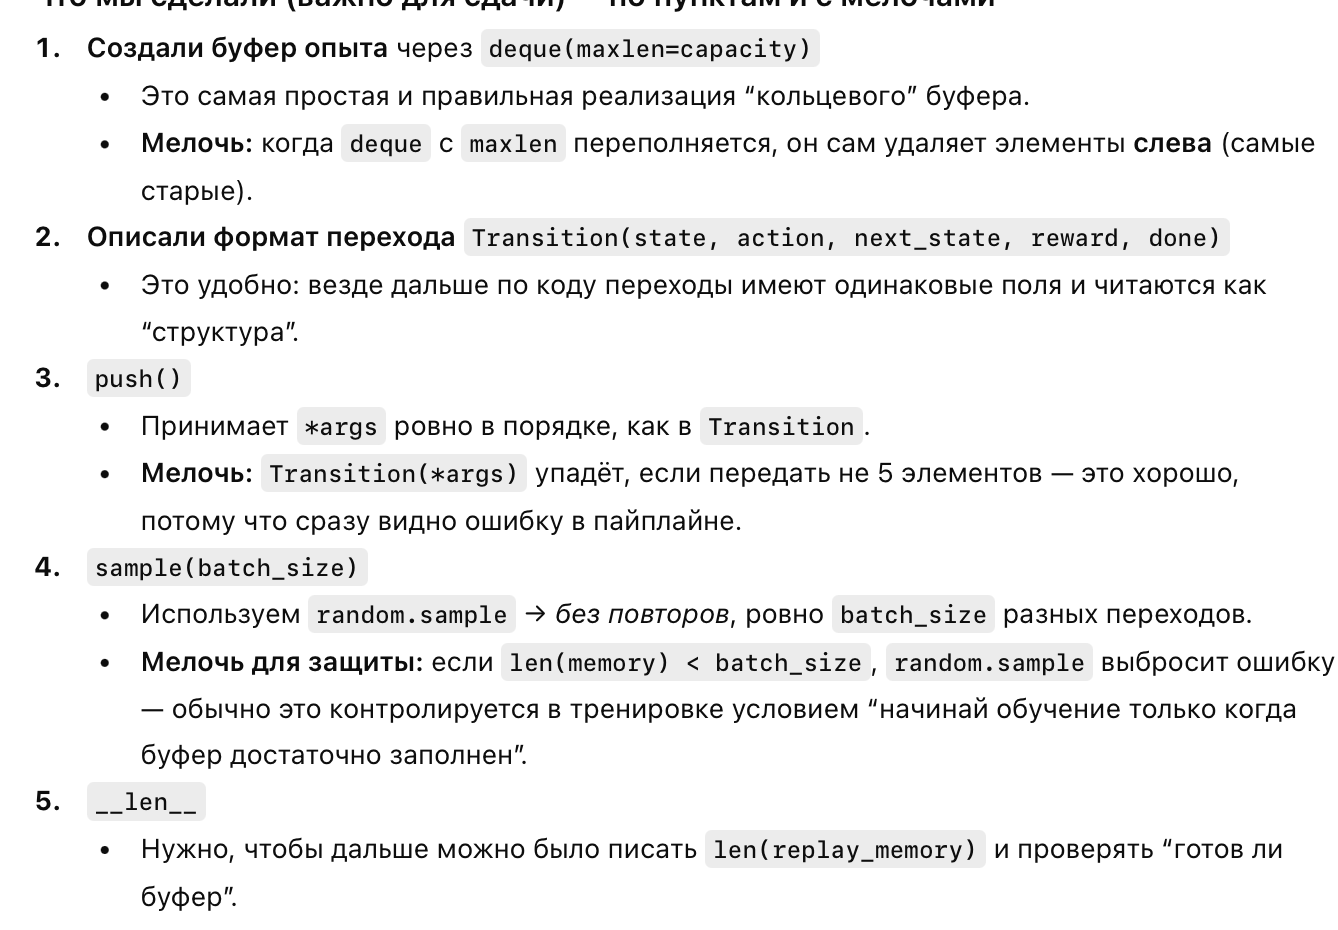

<p class="task" id="2"></p>

2\. Допишите класс `DQN` для моделирования Q-функции. 

- [ ] Проверено на семинаре

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    """Нейронная сеть для моделирования Q-функции."""
    def __init__(self, n_observations, n_actions):
        super().__init__()
        
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        """Для каждого состояния должны получать n_actions чисел."""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

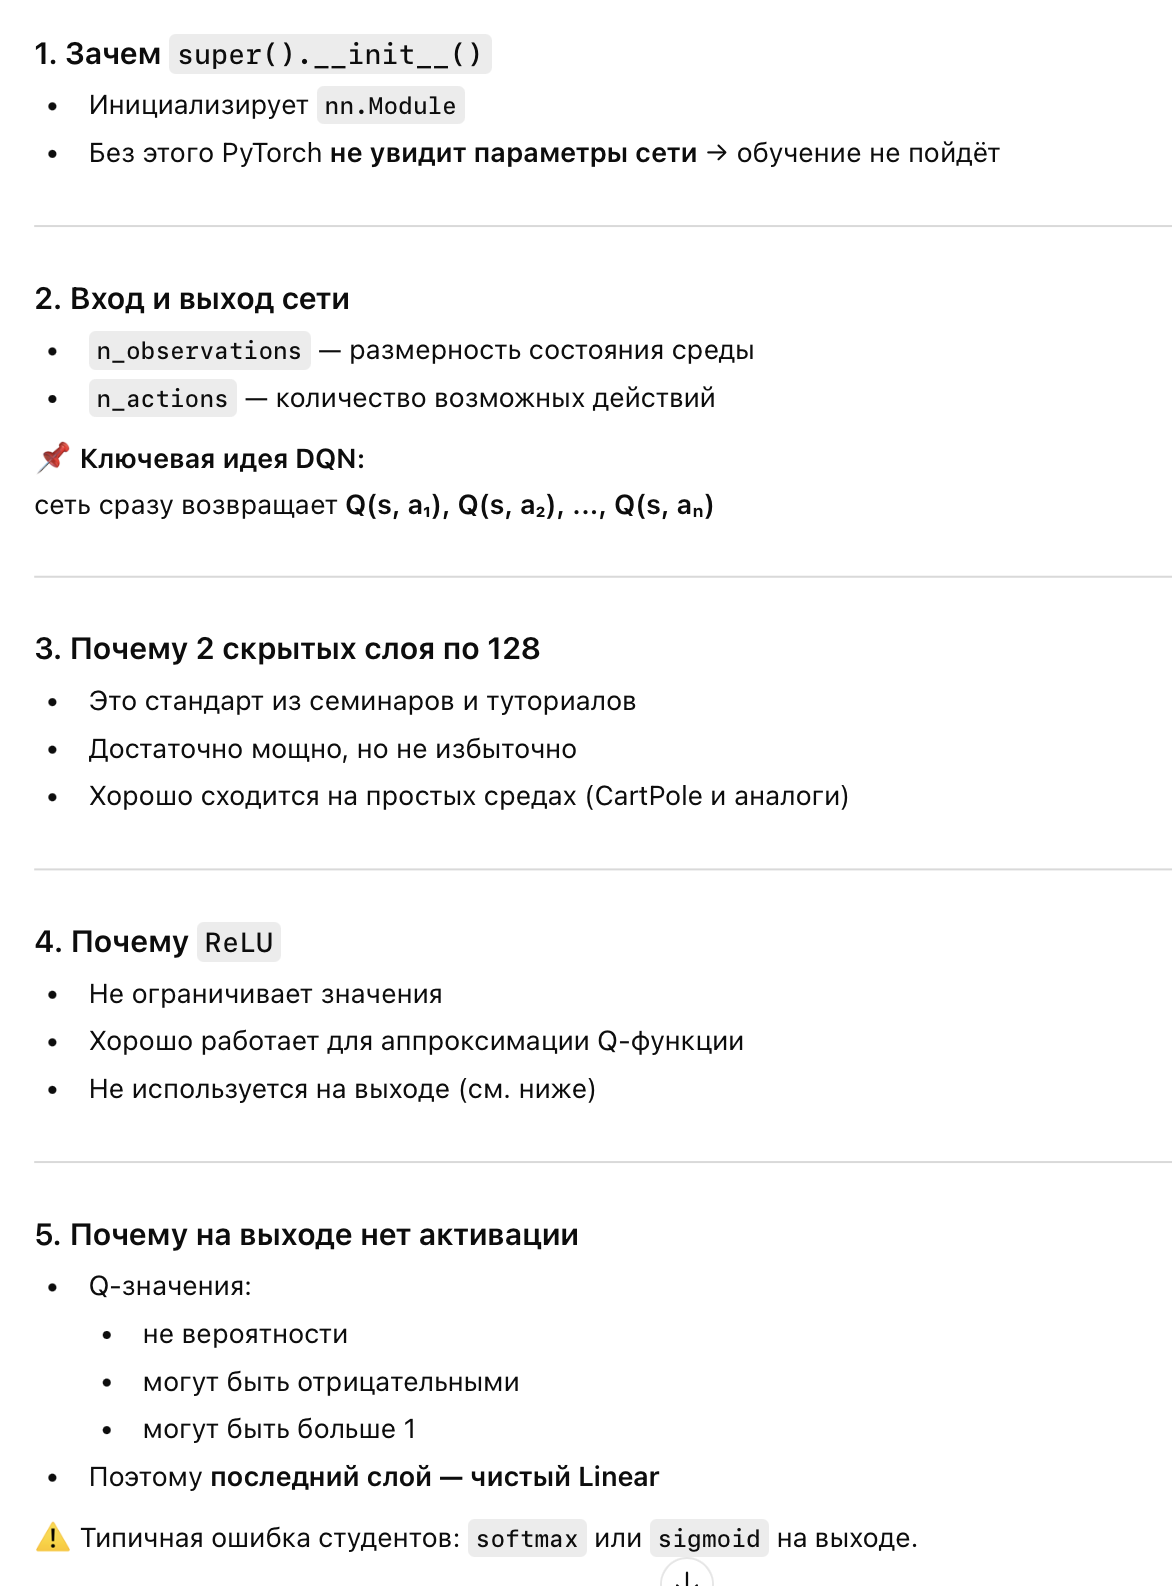

<p class="task" id="3"></p>

3\. Допишите классы `PolicyConfig` для настроек политики агента и `Policy` для реализации политики. 

- [ ] Проверено на семинаре

In [4]:
from dataclasses import dataclass
import torch as th

@dataclass
class PolicyConfig:
    """Содержит настройки для Policy: размерность пространства наблюдений, кол-во действий, 
    устройство, на котором будет располагаться модели; ε и т.д."""
    n_observations: int
    n_actions: int
    device: th.device

    eps_start: float = 0.9
    eps_end: float = 0.05
    eps_decay: float = 1000.0

    save_dir: str = "./checkpoints"
    policy_fname: str = "policy_net.pt"
    target_fname: str = "target_net.pt"

In [ ]:
class Policy:
    def __init__(self, policy_cfg: PolicyConfig):
        # создайте две версии DQN.
        self.policy_network = ... # эту версию используем для обучения на каждом шаге
        self.target_network = ... # эту версию используем для прогноза на каждом шаге
        self.sync_models()
        pass
    
    def sync_models(self):
        # загрузите веса из модели self.policy_network в self.target_network
        pass
        
    def get_best_action(self, state: th.Tensor) -> int:
        # реализуйте ε-жадную стратегию выбора 
        pass
        
    def save(self):
        # метод для сохранения моделей на диск
        pass
    
    def load(self):
        # метод для сохранения моделей с диска
        pass

In [5]:
class Policy:
    def __init__(self, policy_cfg: PolicyConfig):
        self.cfg = policy_cfg
        self.steps_done = 0

        # две версии DQN
        self.policy_network = DQN(self.cfg.n_observations, self.cfg.n_actions).to(self.cfg.device)
        self.target_network = DQN(self.cfg.n_observations, self.cfg.n_actions).to(self.cfg.device)

        # target сеть не обучаем напрямую
        for p in self.target_network.parameters():
            p.requires_grad_(False)

        self.sync_models()

    def sync_models(self):
        # загрузите веса из модели self.policy_network в self.target_network
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.target_network.eval()

    def get_best_action(self, state: th.Tensor) -> int:
        """
        Реализует ε-жадную стратегию.
        state: тензор состояния формы [n_observations] или [1, n_observations]
        возвращаем: int (номер действия)
        """
        if state.dim() == 1:
            state = state.unsqueeze(0)  # -> [1, n_observations]
        state = state.to(self.cfg.device)

        eps = self.cfg.eps_end + (self.cfg.eps_start - self.cfg.eps_end) * math.exp(
            -self.steps_done / self.cfg.eps_decay
        )
        self.steps_done += 1

        # exploration
        if random.random() < eps:
            return random.randrange(self.cfg.n_actions)

        # exploitation
        with th.no_grad():
            q_values = self.policy_network(state)          # [1, n_actions]
            action = int(q_values.argmax(dim=1).item())    # scalar
            return action

    def save(self):
        # метод для сохранения моделей на диск
        save_dir = Path(self.cfg.save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        th.save(self.policy_network.state_dict(), save_dir / self.cfg.policy_fname)
        th.save(self.target_network.state_dict(), save_dir / self.cfg.target_fname)

    def load(self):
        # метод для загрузки моделей с диска
        save_dir = Path(self.cfg.save_dir)

        self.policy_network.load_state_dict(
            th.load(save_dir / self.cfg.policy_fname, map_location=self.cfg.device)
        )
        self.target_network.load_state_dict(
            th.load(save_dir / self.cfg.target_fname, map_location=self.cfg.device)
        )

        self.policy_network.to(self.cfg.device).train()
        self.target_network.to(self.cfg.device).eval()

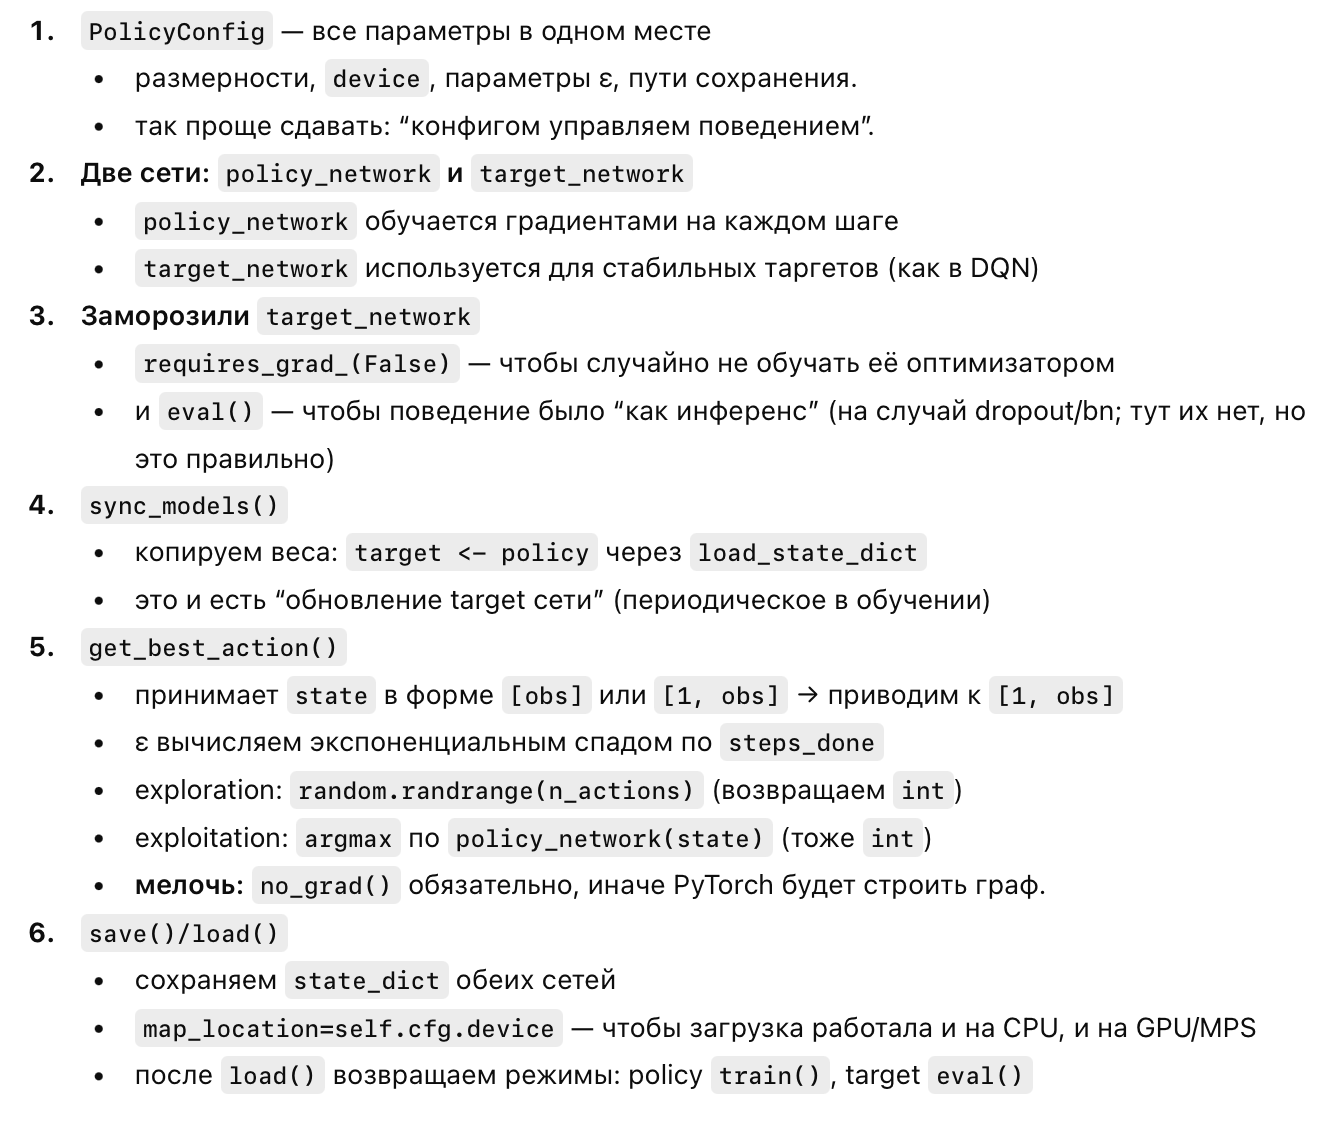

<p class="task" id="4"></p>

4\. Напишите функцию `plot_metrics`, которая будет использоваться для визуализации процесса обучения: суммарной награды за каждый эпизод и максимальное значение x-координаты машины за эпизод. Для реализации можете воспользоваться `wandb` или любым другим удобным инструментом. 

- [ ] Проверено на семинаре

In [6]:
from typing import List, Optional
import matplotlib.pyplot as plt

def plot_metrics(
    episode_rewards: List[float],
    episode_max_x: List[float],
    window: int = 20,
    use_wandb: bool = False,
    step_offset: int = 0,
):
    """
    Визуализирует обучение:
    - суммарная награда за эпизод
    - максимальная x-координата (позиция) за эпизод

    window: окно для скользящего среднего (0 или 1 -> без сглаживания)
    use_wandb: если True и wandb инициализирован, логируем метрики
    step_offset: если продолжаем обучение/логирование не с нуля
    """

    n = min(len(episode_rewards), len(episode_max_x))
    if n == 0:
        return
    rewards = episode_rewards[:n]
    max_x = episode_max_x[:n]
    episodes = list(range(1 + step_offset, n + 1 + step_offset))

    def moving_avg(xs, w):
        if w <= 1 or len(xs) < w:
            return None
        return [sum(xs[i - w:i]) / w for i in range(w, len(xs) + 1)]

    # --- Plot ---
    plt.figure(figsize=(12, 4))

    # Rewards
    plt.subplot(1, 2, 1)
    plt.plot(episodes, rewards, label="reward")
    r_ma = moving_avg(rewards, window)
    if r_ma is not None:
        plt.plot(episodes[window - 1 :], r_ma, label=f"reward MA({window})")
    plt.title("Episode reward")
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.grid(True)
    plt.legend()

    # Max X
    plt.subplot(1, 2, 2)
    plt.plot(episodes, max_x, label="max x")
    x_ma = moving_avg(max_x, window)
    if x_ma is not None:
        plt.plot(episodes[window - 1 :], x_ma, label=f"max x MA({window})")
    plt.title("Max x per episode")
    plt.xlabel("Episode")
    plt.ylabel("Max x")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- Optional: wandb logging ---
    if use_wandb:
        try:
            import wandb
            last_ep = episodes[-1]
            wandb.log(
                {
                    "episode": last_ep,
                    "reward/episode": rewards[-1],
                    "max_x/episode": max_x[-1],
                },
                step=last_ep,
            )
        except Exception:
            # если wandb не установлен или не init — просто молча пропускаем
            pass


<p class="task" id="5"></p>

5\. Допишите классы `TrainConfig` для настроек обучения и `Trainer` для реализации процесса обучения. 

- [ ] Проверено на семинаре

In [7]:
@dataclass
class TrainConfig:
    """Содержит настройки для процесса обучения: к-т дисконтирования, скорость обучения, 
    количество эпизодов для обучения, размер батча и т.д."""
    gamma: float = 0.99
    lr: float = 1e-3
    n_episodes: int = 400

    batch_size: int = 64
    memory_capacity: int = 50_000

    target_sync_every: int = 10   # раз в сколько эпизодов синхронизировать target сеть
    max_steps_per_episode: int = 200

    grad_clip: float = 1.0        # 0 -> без клиппинга
    plot_every: int = 10

In [ ]:
import gymnasium as gym

class Trainer:
    def __init__(self, env: gym.Env, train_config: TrainConfig, policy: Policy):
        # создайте критерий и оптимизатор для настройки модели policy.policy_network
        # создайте объект для хранения переходов
        self.memory = ...
        self.policy = policy
        pass
    
    
    def train(self):
        # метод для старта обучения
        # - итерация по эпизодам (run_episode)
        # - сохранение метрик за эпизод
        # - визуализация
        # - сохранение модели при улучшении качества (максимального значения по оси x, которого удалось достичь)
        pass
    
    def run_episode(self, start_state: th.Tensor):
        # метод для прогона эпизода
        # - генерация переходов и их сохранение
        # - запуск генерации батча и обучения (generate_batch_and_fit)
        # - синхронизация моделей (policy и target) - не обязательно на каждом шаге
        # не забудьте уменьшить ε в процессе обучения
    
    def generate_batch_and_fit(self)
        # генерируем батч на основе хранилища
        transitions = ...
        # получаем набор текущих состояний и следующих состояний
        states = ...
        next_states = ...
        
        # получаем прогнозы для текущих состояний и следующих состояний
        targets = self.policy.policy_network(...)
        next_state_targets = self.policy.target_network(...)
        
        # модифицируем targets: если сессия закончена, то targets[t.action] = t.reward
        # если нет, то targets[t.action] = t.reward + gamma * max(next_state_targets[i])
        # t - переход из батча с номером i
        
        # вызываем fit_policy_network
    
    def fit_policy_network(self, X, y):
        # напишите код для обучения модели
        # X - батч состояний (batch_size x 2)
        # y - набор Q-значений (batch_size x 3)
        pass

In [8]:
from dataclasses import dataclass
import numpy as np
import torch as th
import torch.nn as nn

# предполагается, что ReplayMemory и Transition уже определены (из №1)
# и Policy / PolicyConfig / DQN уже определены (из №3)

@dataclass
class TrainConfig:
    """Настройки обучения"""
    gamma: float = 0.99
    lr: float = 1e-3
    n_episodes: int = 400

    batch_size: int = 64
    memory_capacity: int = 50_000

    target_sync_every: int = 10   # раз в сколько эпизодов синхронизировать target сеть
    max_steps_per_episode: int = 200

    grad_clip: float = 1.0        # 0 -> без клиппинга
    plot_every: int = 10          # как часто вызывать plot_metrics


import gymnasium as gym

class Trainer:
    def __init__(self, env: gym.Env, train_config: TrainConfig, policy: Policy):
        self.env = env
        self.cfg = train_config
        self.policy = policy

        # критерий + оптимизатор для policy.policy_network
        self.criterion = nn.MSELoss()
        self.optimizer = th.optim.Adam(self.policy.policy_network.parameters(), lr=self.cfg.lr)

        # replay buffer
        self.memory = ReplayMemory(self.cfg.memory_capacity)

        # метрики обучения
        self.episode_rewards = []
        self.episode_max_x = []

    def train(self):
        for ep in range(1, self.cfg.n_episodes + 1):
            total_reward, max_x = self.run_episode()

            self.episode_rewards.append(float(total_reward))
            self.episode_max_x.append(float(max_x))

            # периодически синхронизируем target сеть
            if ep % self.cfg.target_sync_every == 0:
                self.policy.sync_models()

            # визуализация метрик
            if ep % self.cfg.plot_every == 0:
                plot_metrics(self.episode_rewards, self.episode_max_x)

        # финальный график
        plot_metrics(self.episode_rewards, self.episode_max_x)

    def run_episode(self):
        state, _ = self.env.reset()
        total_reward = 0.0
        max_x = float(state[0])  # MountainCar: state = [position, velocity]

        for _ in range(self.cfg.max_steps_per_episode):
            # action выбираем ε-greedy (ε убывает внутри Policy по steps_done)
            action = self.policy.get_best_action(th.tensor(state, dtype=th.float32))

            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = bool(terminated or truncated)

            total_reward += float(reward)
            max_x = max(max_x, float(next_state[0]))

            # сохраняем переход в replay buffer
            self.memory.push(
                th.tensor(state, dtype=th.float32),
                int(action),
                th.tensor(next_state, dtype=th.float32),
                float(reward),
                done
            )

            state = next_state

            # как только накопили достаточно — тренируемся на батче
            if len(self.memory) >= self.cfg.batch_size:
                X, y = self.generate_batch(self.cfg.batch_size)
                self.fit_policy_network(X, y)

            if done:
                break

        return total_reward, max_x

    def generate_batch(self, batch_size: int):
        batch = self.memory.sample(batch_size)

        # (batch_size, obs_dim)
        states = th.stack([t.state for t in batch]).to(self.policy.cfg.device)
        next_states = th.stack([t.next_state for t in batch]).to(self.policy.cfg.device)

        actions = th.tensor([t.action for t in batch], dtype=th.long, device=self.policy.cfg.device)
        rewards = th.tensor([t.reward for t in batch], dtype=th.float32, device=self.policy.cfg.device)
        dones = th.tensor([t.done for t in batch], dtype=th.bool, device=self.policy.cfg.device)

        # targets: текущее предсказание Q(s, ·) (его будем модифицировать по Bellman)
        self.policy.policy_network.train()
        targets = self.policy.policy_network(states)

        # Q(next_state, ·) берём из target-сети и без градиентов
        with th.no_grad():
            next_q = self.policy.target_network(next_states)               # (B, n_actions)
            next_q_max = next_q.max(dim=1).values                          # (B,)

        # Bellman target для выбранного action:
        # y = r, если done
        # y = r + gamma * max_a' Q_target(s', a'), если не done
        updated = rewards + (~dones).float() * (self.cfg.gamma * next_q_max)

        # заменяем targets[i, action_i] на updated[i]
        targets = targets.detach().clone()  # важно: не тащим градиент через "старые" targets
        targets[th.arange(batch_size, device=self.policy.cfg.device), actions] = updated

        return states, targets

    def fit_policy_network(self, X, y):
        self.optimizer.zero_grad()

        pred = self.policy.policy_network(X)
        loss = self.criterion(pred, y)

        loss.backward()

        if self.cfg.grad_clip and self.cfg.grad_clip > 0:
            th.nn.utils.clip_grad_norm_(self.policy.policy_network.parameters(), self.cfg.grad_clip)

        self.optimizer.step()


<p class="task" id="6"></p>

6\. Настройте модель для управления машиной в окружении `MountainCar-v0`. Для преобразования векторов состояний в тензоры используйте обертку `TransformObservation`. Выведите на экран график с информацией о процессе обучения. При необходимости вставьте скриншоты этих графиков.

- [ ] Проверено на семинаре

Device: mps


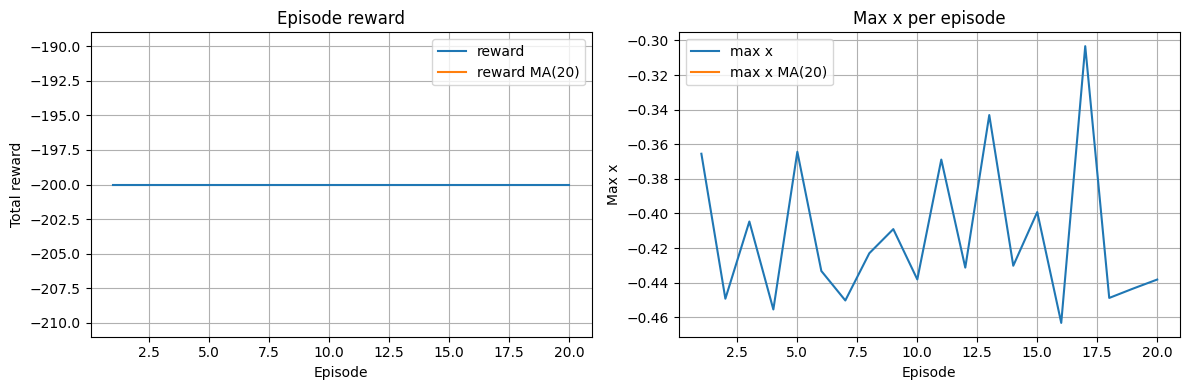

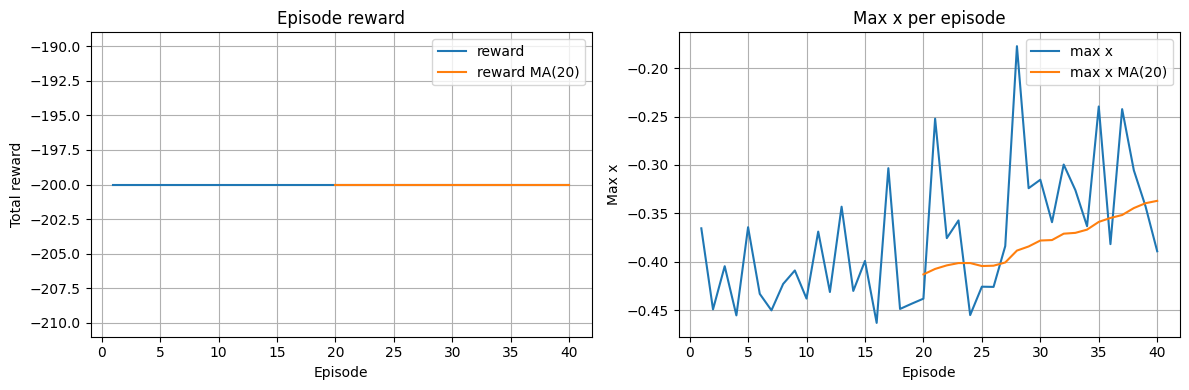

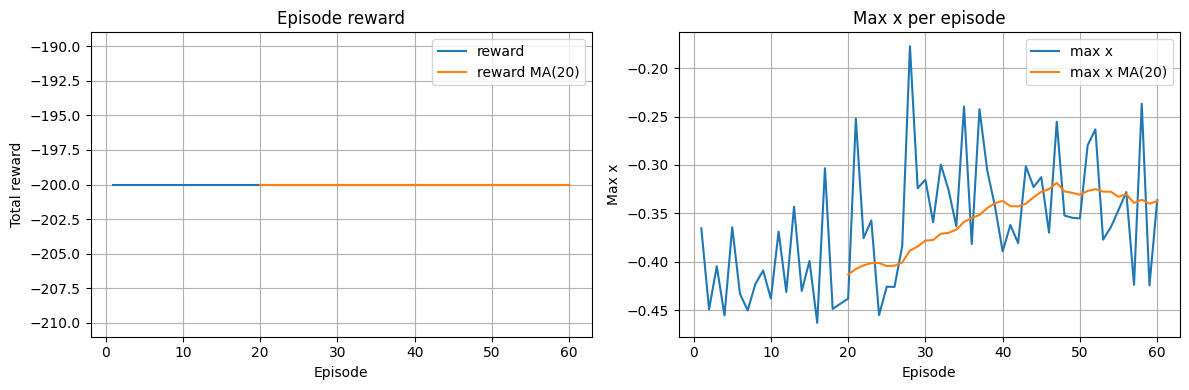

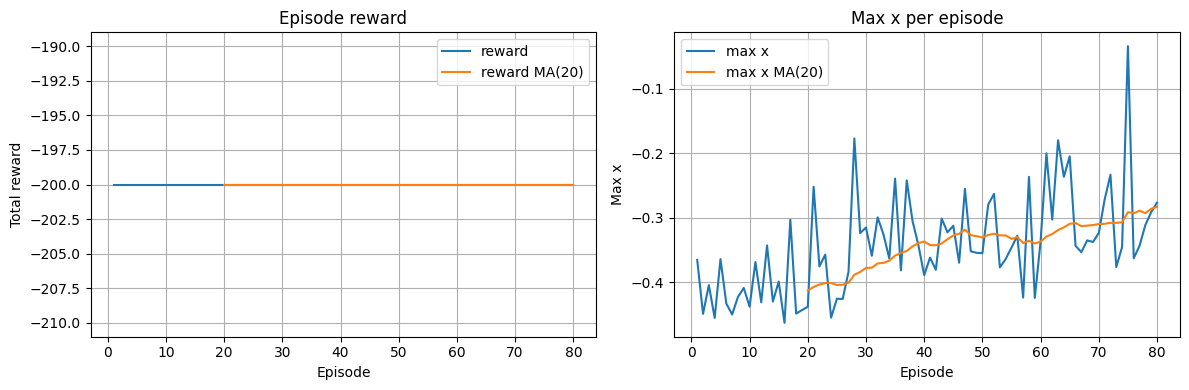

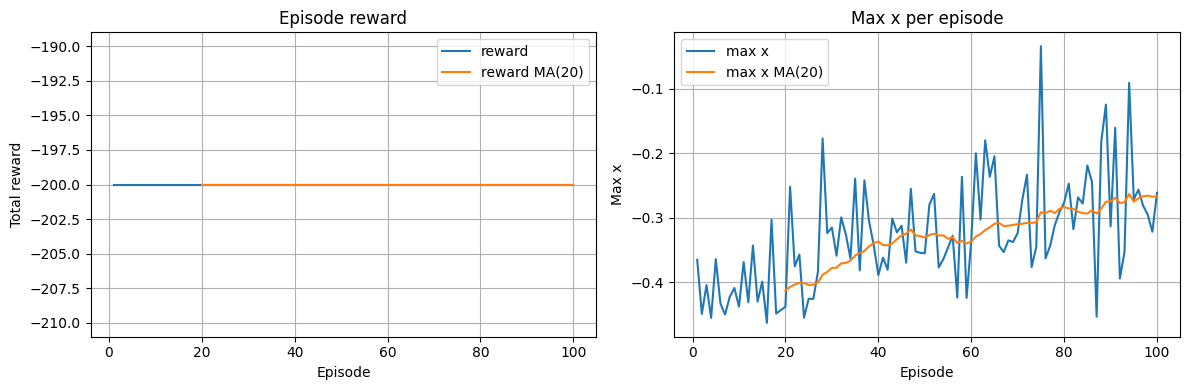

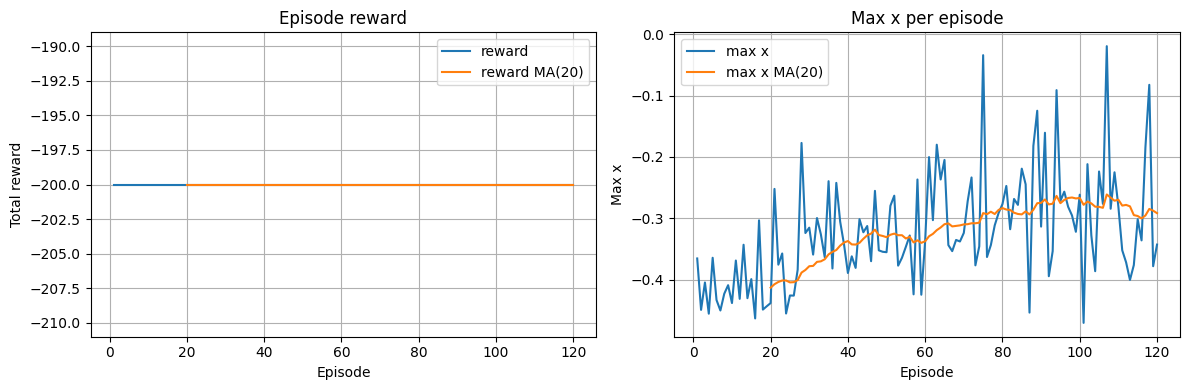

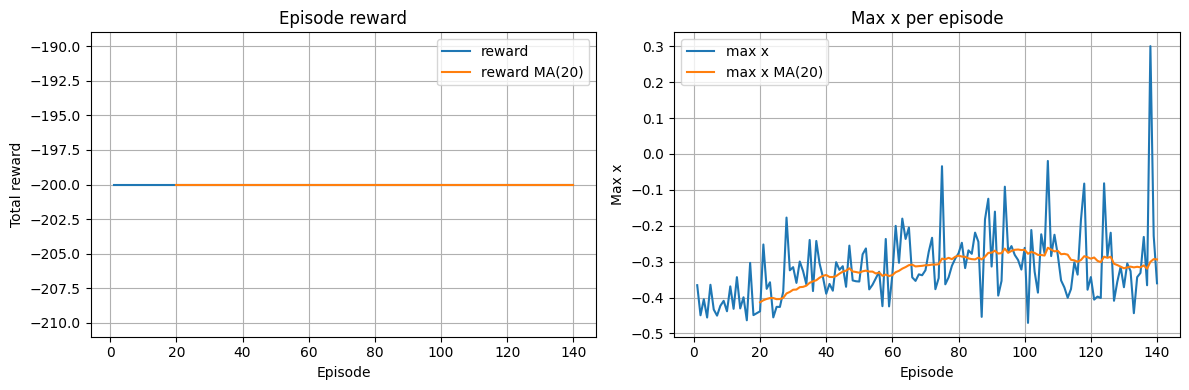

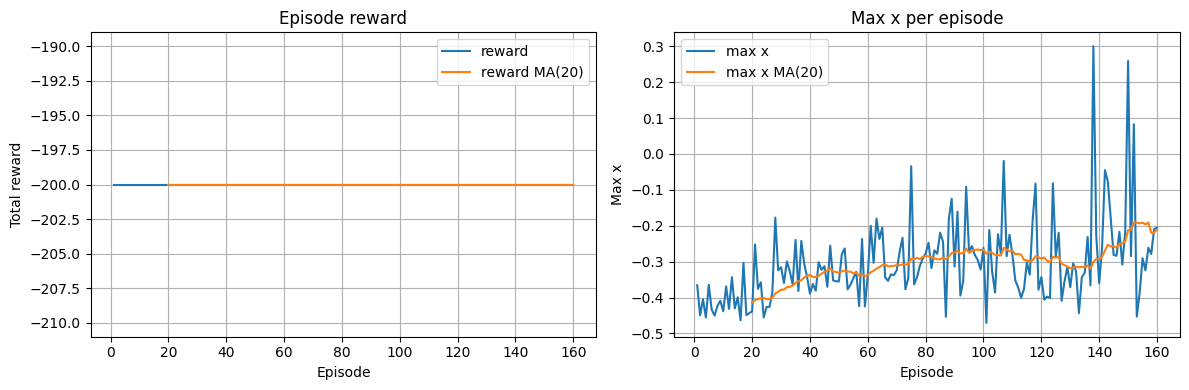

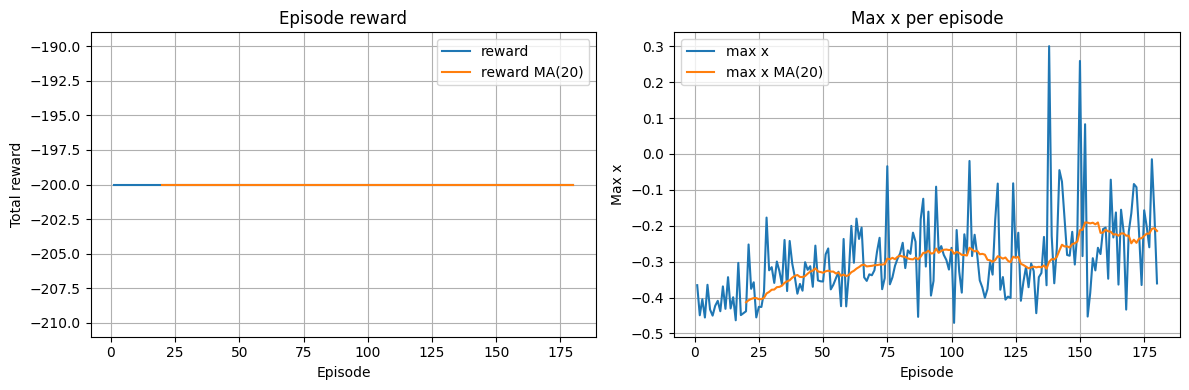

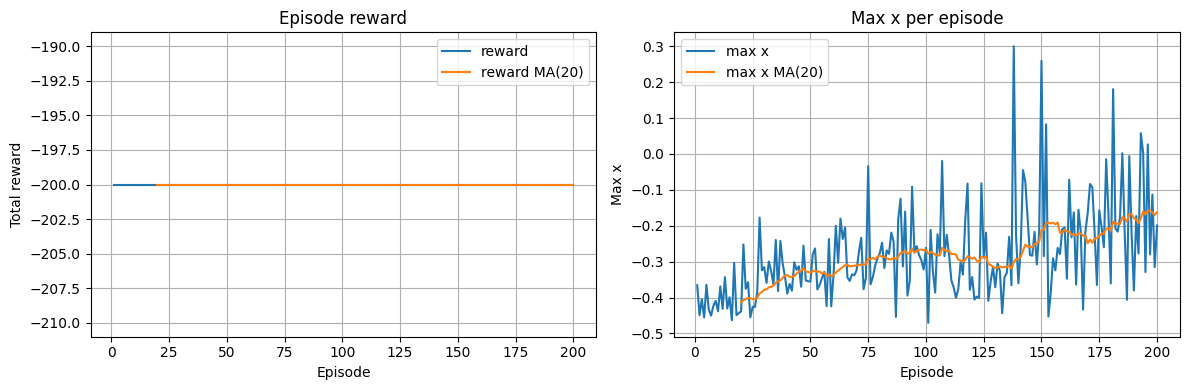

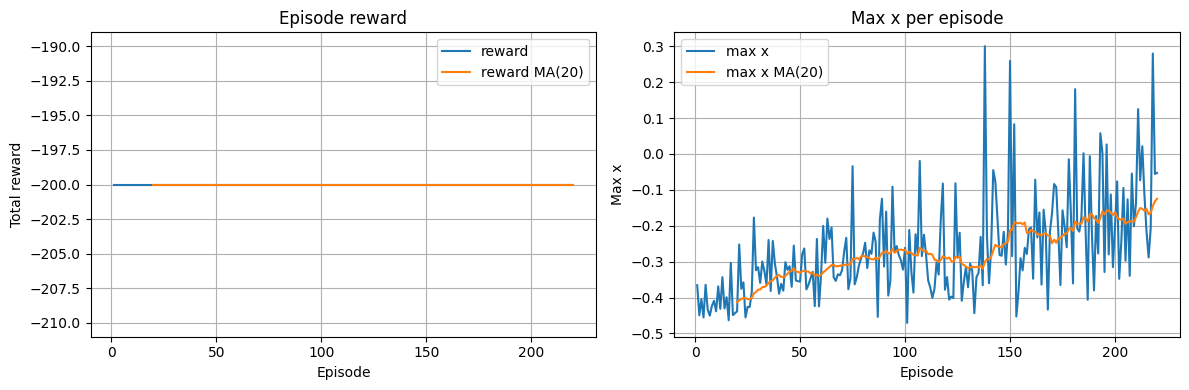

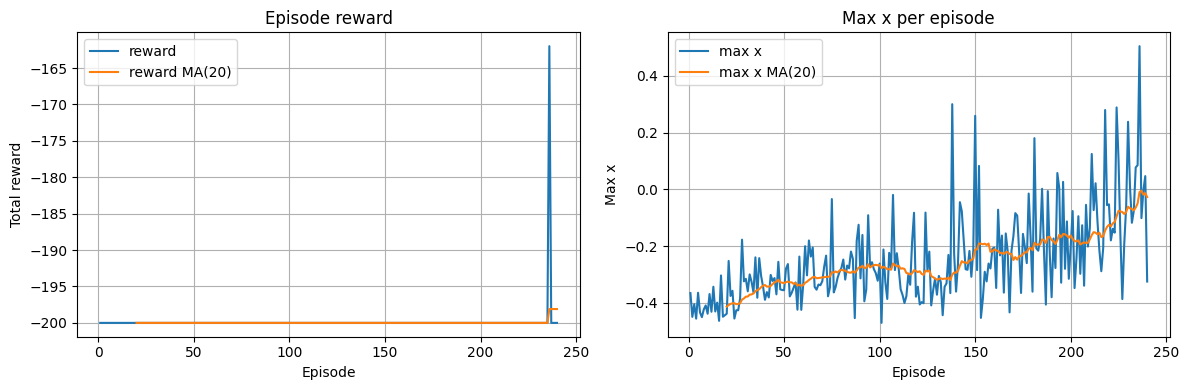

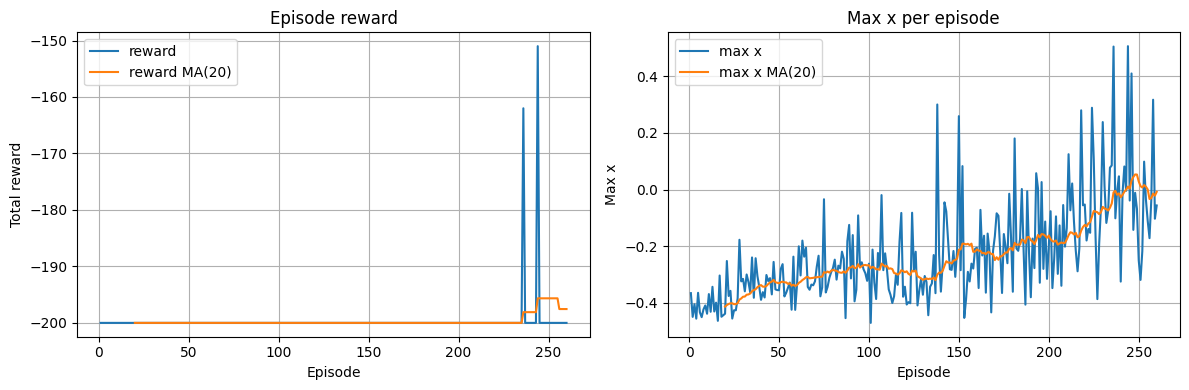

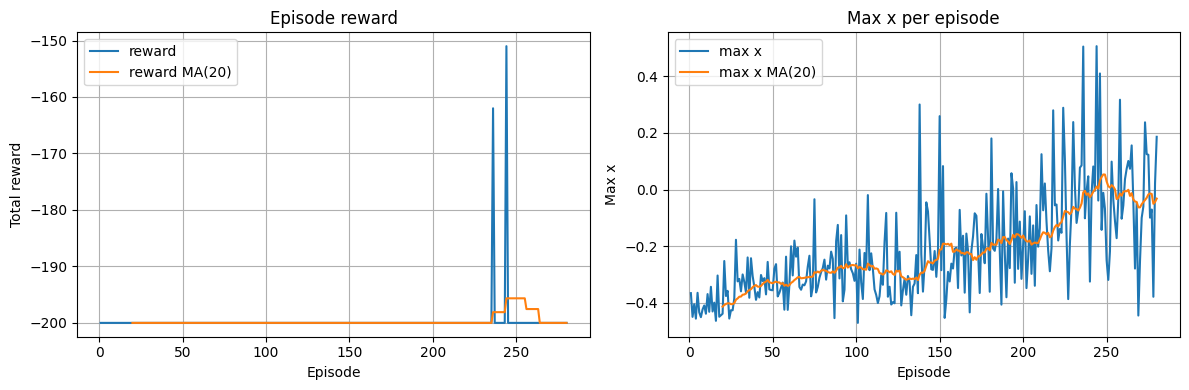

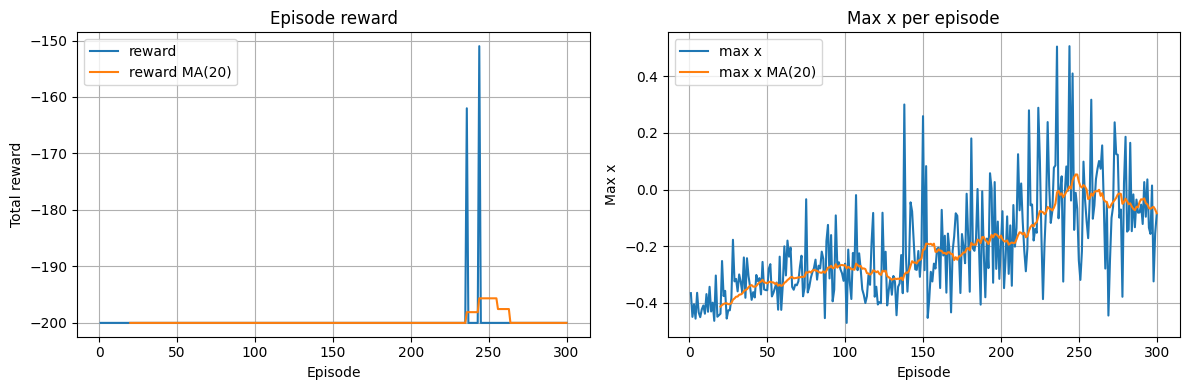

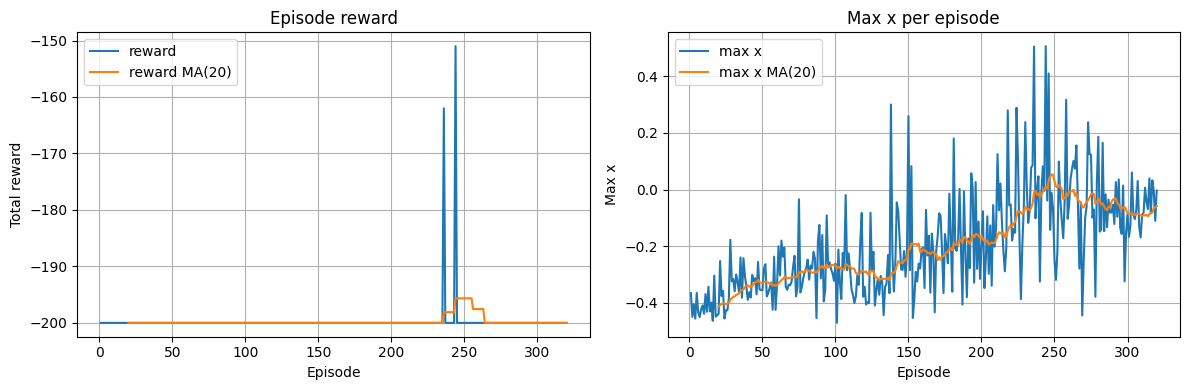

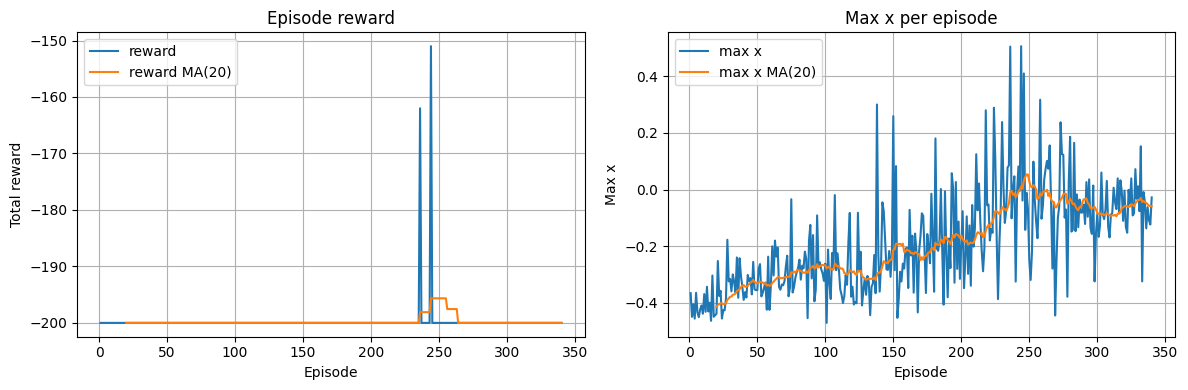

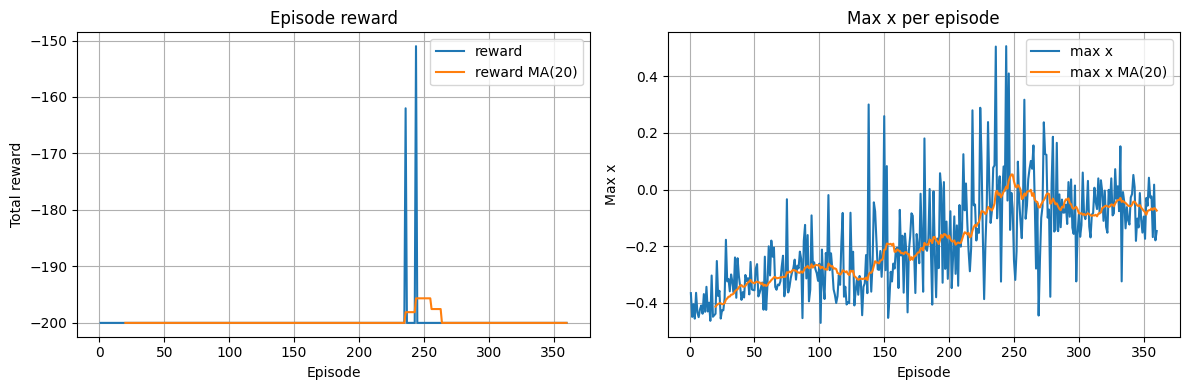

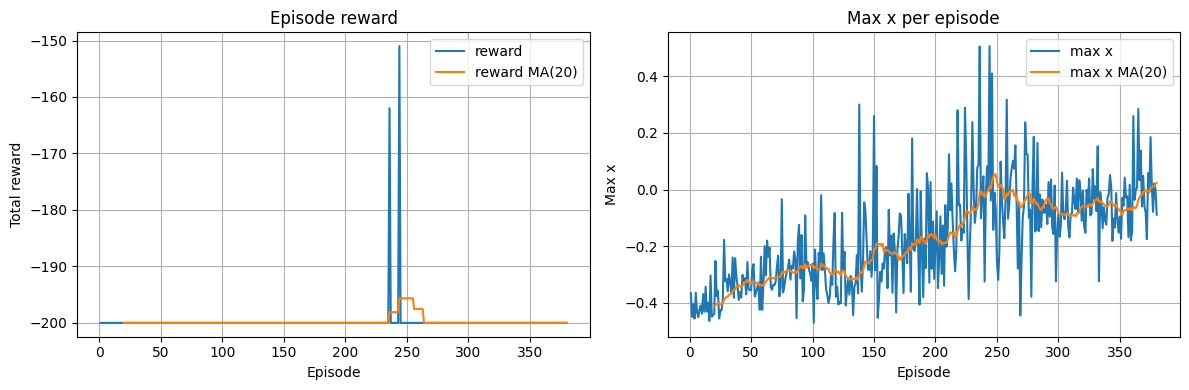

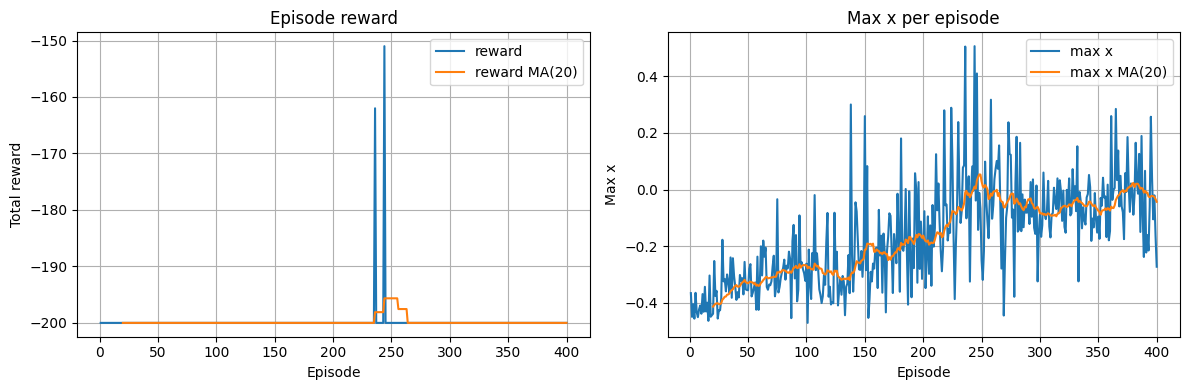

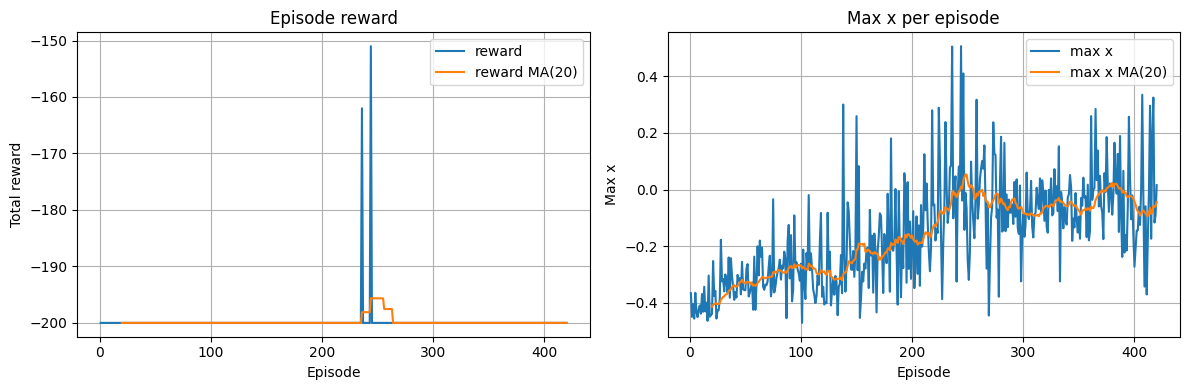

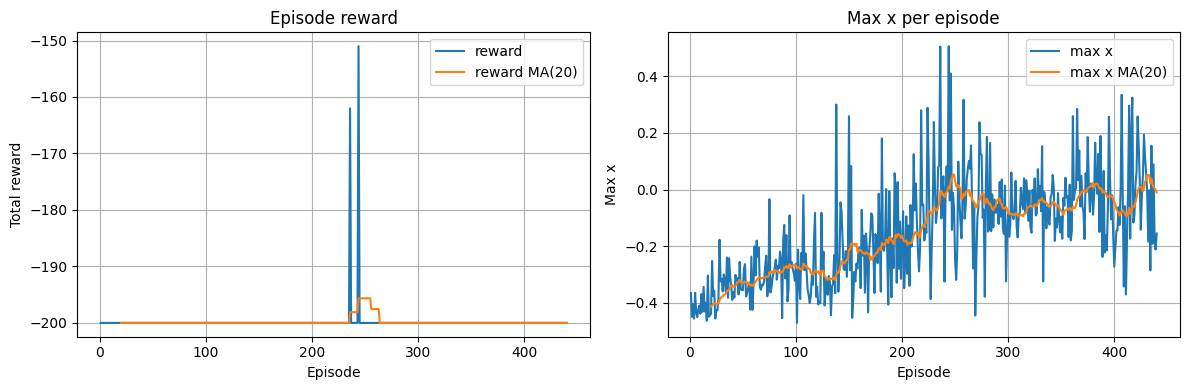

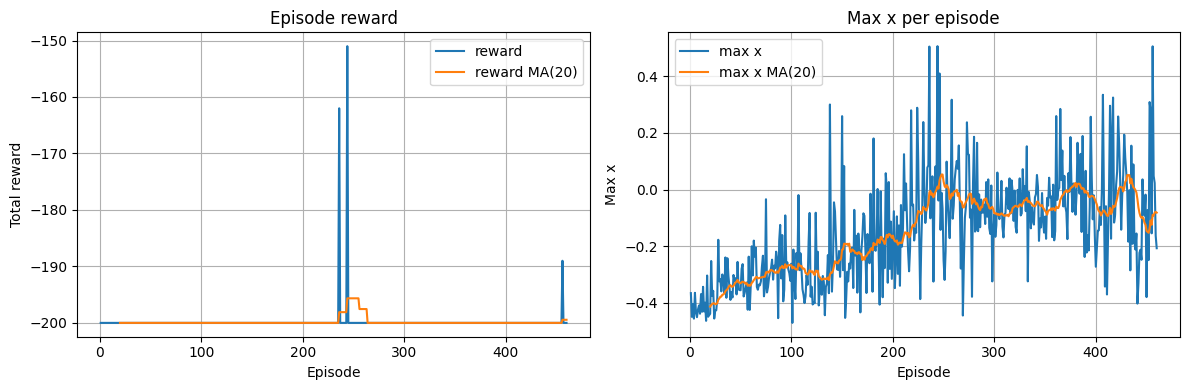

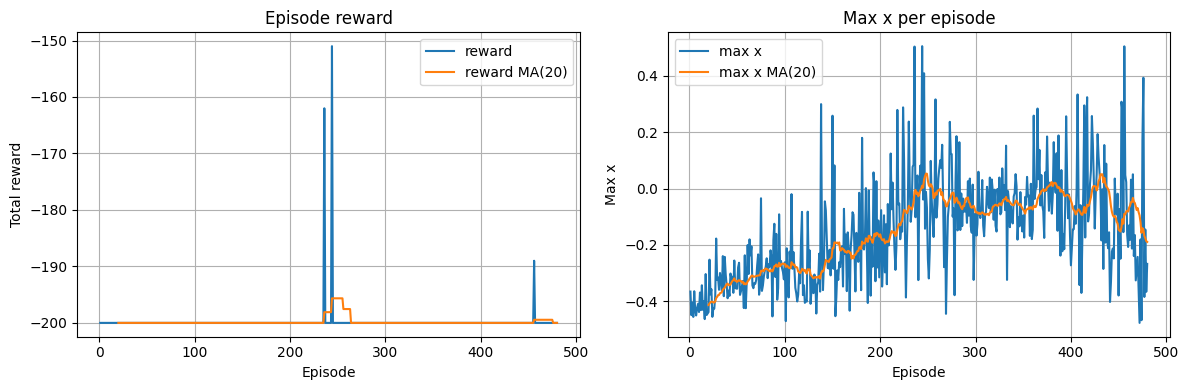

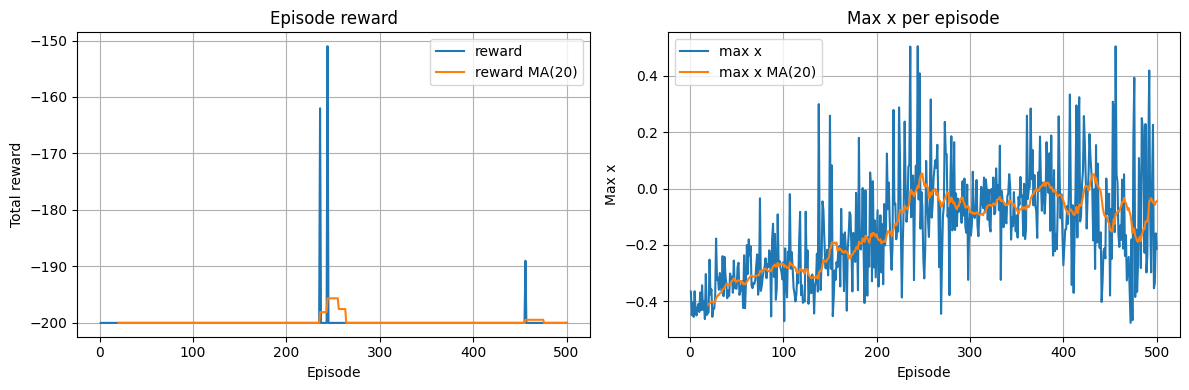

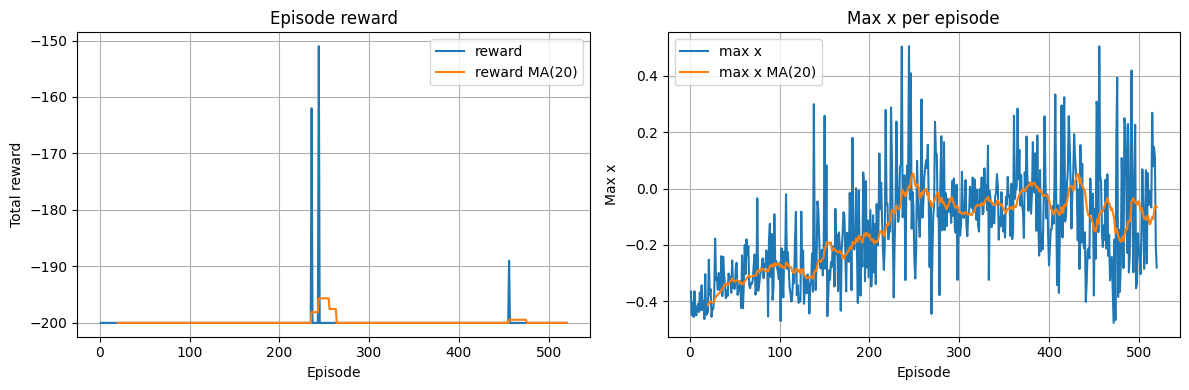

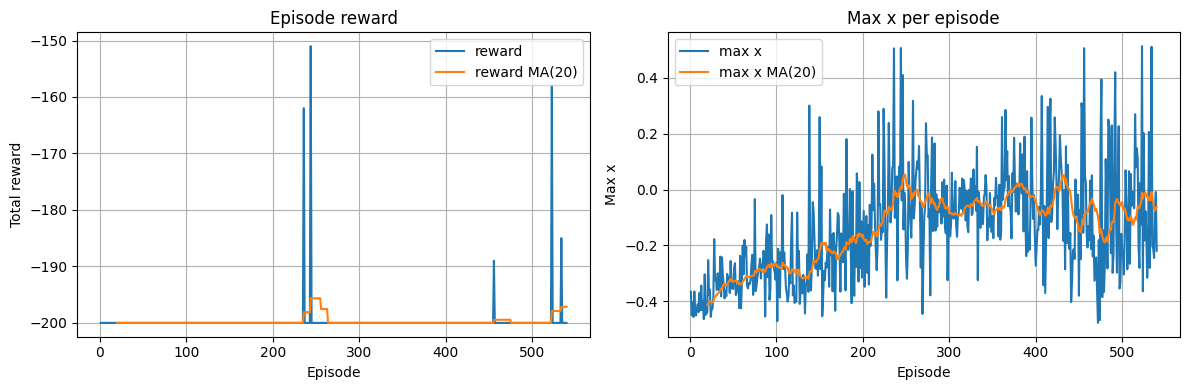

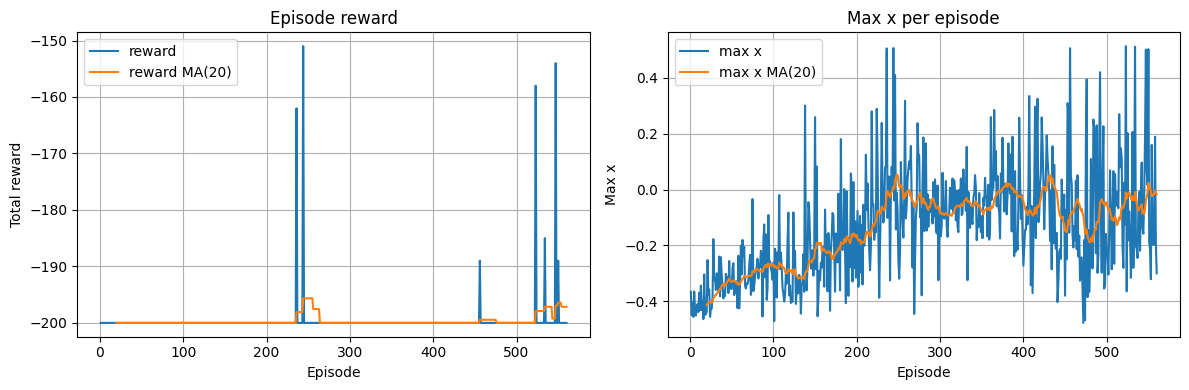

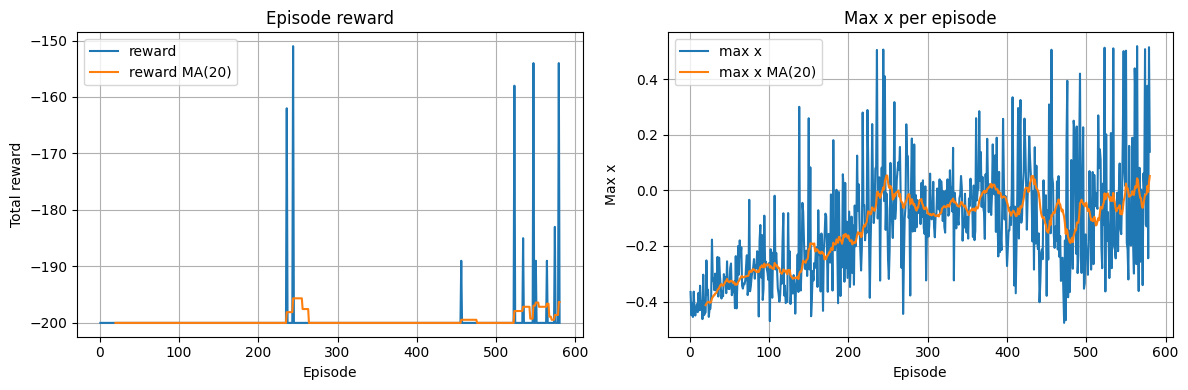

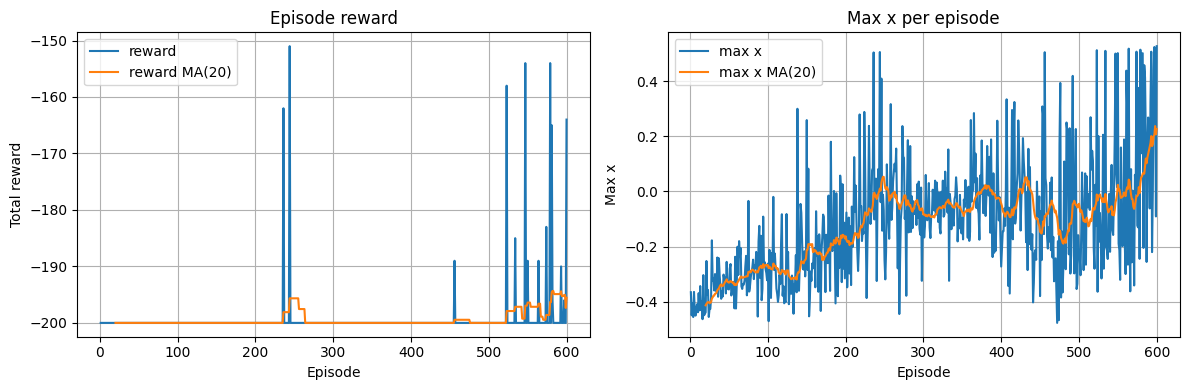

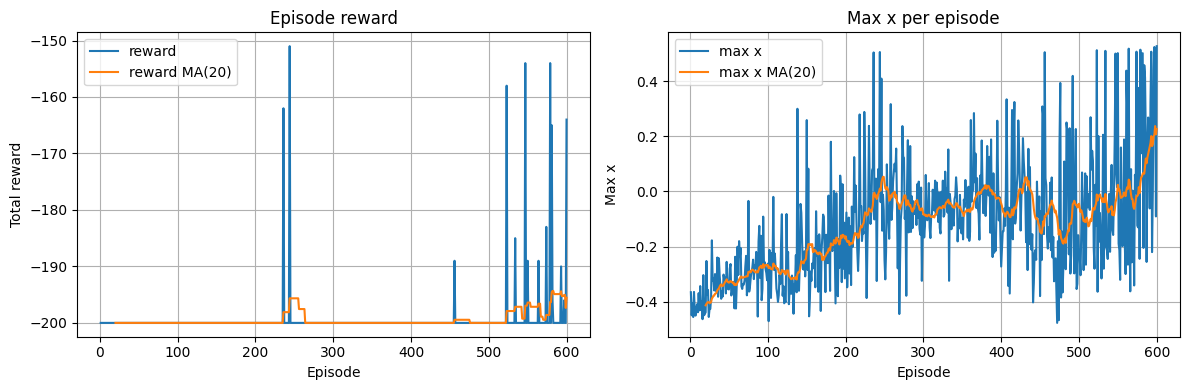

In [13]:
import gymnasium as gym
import torch as th
import numpy as np

# 1) Выбираем устройство
def get_device():
    if th.cuda.is_available():
        return th.device("cuda")
    if hasattr(th.backends, "mps") and th.backends.mps.is_available():
        return th.device("mps")
    return th.device("cpu")

device = get_device()
print("Device:", device)

# 2) Создаём окружение
env = gym.make("MountainCar-v0")

# 3) Достаём размерности
n_observations = env.observation_space.shape[0]   # обычно 2 (position, velocity)
n_actions = env.action_space.n                   # обычно 3 (left, idle, right)

# 4) Конфиги (их можно тюнить)
policy_cfg = PolicyConfig(
    n_observations=n_observations,
    n_actions=n_actions,
    device=device,
    eps_start=1.0,     # для MountainCar лучше начать с сильного exploration
    eps_end=0.05,
    eps_decay=5000.0,  # медленнее уменьшаем epsilon (важно!)
    save_dir="./checkpoints"
)

train_cfg = TrainConfig(
    gamma=0.99,
    lr=1e-3,
    n_episodes=600,          # MountainCar часто требует больше эпизодов
    batch_size=128,
    memory_capacity=100_000,
    target_sync_every=10,
    max_steps_per_episode=200,
    grad_clip=1.0,
    plot_every=20
)

# 5) Собираем Policy и Trainer
policy = Policy(policy_cfg)
trainer = Trainer(env, train_cfg, policy)

# 6) Тренируем
trainer.train()

# 7) Сохраняем веса
policy.save()


In [12]:
import math
from pathlib import Path